In [5]:
import copy
import glob
import os
import time
from collections import deque
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import gym
import gym_nav
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate


In [2]:
env_name = 'Gridworld-v0'
log_dir = '/tmp/gym'
device = torch.device("cpu")
alg = 'ppo'
log_interval = 10

value_loss_coef = 0.5
entropy_coef = 0.01
gamma = 0.99
lr = 7e-4
eps = 1e-5
alpha = 0.99
max_grad_norm = 0.5

clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1

num_env_steps = 10000
num_steps = 5
num_processes = 1

use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False

env = gym.make(env_name)
envs = make_vec_envs(env_name, 0, 1, gamma, log_dir, device, False, capture_video=1, 
                     env_kwargs={'reward_shaping': 2})

actor_critic = Policy(
    envs.observation_space.shape,
    envs.action_space,
    base_kwargs={'recurrent': True})
actor_critic.to(device)

if alg == 'a2c':
        agent = algo.A2C_ACKTR(
            actor_critic,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            alpha=alpha,
            max_grad_norm=max_grad_norm)
elif alg == 'ppo':
    agent = algo.PPO(
        actor_critic,
        clip_param,
        ppo_epoch,
        num_mini_batch,
        value_loss_coef,
        entropy_coef,
        lr=lr,
        eps=eps,
        max_grad_norm=max_grad_norm)

global_step = 0

rollouts = RolloutStorage(num_steps, num_processes,
                          envs.observation_space.shape, envs.action_space,
                          actor_critic.recurrent_hidden_state_size)

obs = envs.reset()
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

start = time.time()
num_updates = int(
    num_env_steps) // num_steps // num_processes
for j in range(num_updates):

    for step in range(num_steps):
        #Andy: add global step
        global_step += 1 * num_processes
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                rollouts.masks[step])

        # Obser reward and next obs
        obs, reward, done, infos = envs.step(action)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])

        # If done then clean the history of observations.
        masks = torch.FloatTensor(
            [[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor(
            [[0.0] if 'bad_transition' in info.keys() else [1.0]
             for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action,
                        action_log_prob, value, reward, masks, bad_masks)

    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
            rollouts.masks[-1]).detach()
        
    rollouts.compute_returns(next_value, use_gae, gamma,
                             gae_lambda, use_proper_time_limits)

    if alg == 'ppo':
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs = \
        agent.update(rollouts)

    else:
        value_loss, action_loss, dist_entropy = agent.update(rollouts)

    rollouts.after_update()

    if j % log_interval == 0 and len(episode_rewards) > 1:
        total_num_steps = (j + 1) * num_processes * num_steps
        end = time.time()
        print(
            "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
            .format(j, total_num_steps,
                    int(total_num_steps / (end - start)),
                    len(episode_rewards), np.mean(episode_rewards),
                    np.median(episode_rewards), np.min(episode_rewards),
                    np.max(episode_rewards), dist_entropy, value_loss,
                    action_loss))



C:\Users\Andy\miniconda3\lib\site-packages\gym\wrappers\record_video.py:42: UserWarning: WARN: Overwriting existing videos at C:\Users\Andy\Desktop\Work\github\training-rl-algo\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Updates 80, num timesteps 405, FPS 70 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 90, num timesteps 455, FPS 70 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 100, num timesteps 505, FPS 66 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 110, num timesteps 555, FPS 66 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 120, num timesteps 605, FPS 65 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2

Updates 130, num timesteps 655, FPS 66 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2

Updates 140, num timesteps 705, FPS 64 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2

Updates 150, num timesteps 755, FPS 65 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2



KeyboardInterrupt: 

In [5]:
env = gym.make('Gridworld-v0', reward_shaping=2)

In [6]:
env.reset()

array([1., 1., 1., 1., 0.])

In [33]:
env.step(1)

(array([1., 1., 6., 1., 1.]), 1.01, True, {})

In [2]:
env = gym.make('NavEnv-v0')

pygame 2.1.2 (SDL 2.0.18, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
env.reset()

array([0.        , 0.95582287, 0.        , 0.        , 0.9598488 ,
       0.        , 0.        , 0.96304543, 0.        , 0.        ,
       0.96558575, 0.        , 0.        , 0.96768114, 0.        ,
       0.        , 0.96937654, 0.        , 0.        , 0.970787  ,
       0.        , 0.        , 0.9719262 , 0.        , 0.        ,
       0.97285759, 0.        , 0.        , 0.973612  , 0.        ,
       0.        , 0.97419547, 0.        , 0.        , 0.97463541,
       0.        , 0.        , 0.97494144, 0.        , 0.        ,
       0.97512074, 0.        , 0.        , 0.97517719, 0.        ,
       0.        , 0.9751127 , 0.        , 0.        , 0.97492507,
       0.        , 0.        , 0.97461037, 0.        , 0.        ,
       0.9741612 , 0.        , 0.        , 0.97356778, 0.        ,
       0.        , 0.97280149, 0.        , 0.        , 0.97185712,
       0.        , 0.        , 0.97070304, 0.        , 0.        ,
       0.9692735 , 0.        , 0.        , 0.96755628, 0.     

In [407]:
import numpy as np
import gym
from gym import spaces
import math

MAX_MARCH = 20
EPSILON = 0.1
DEG_TO_RAD = 0.0174533
WINDOW_SIZE = (200, 300) # Width x Height in pixels
MAX_DIST = np.linalg.norm(WINDOW_SIZE)

object_to_idx = {
    'wall': 1,
    'goal': 2
}
color_to_idx = {
    'invisible': 0,
    'red': 1,
    'green': 2,
    'blue': 3,
    'yellow': 4,
    'purple': 5,
    'white': 6
}
idx_to_rgb = {
    1: np.array([230, 0, 0]),
    2: np.array([0, 230, 0]),
    3: np.array([0, 0, 230]),
    4: np.array([230, 230, 0]),
    5: np.array([230, 0, 230]),
    6: np.array([230, 230, 230])
}

def generate_box(pos=None, size=[10, 25], inside_window=True, color=1, is_goal=False):
    '''
    Generate a box with width and height drawn randomly uniformly from size[0] to size[1]
    if inside_window is True, we force the box to stay inside the window
    '''
    box_size = np.random.uniform([size[0], size[0]], [size[1], size[1]])
    if pos is None:
        if inside_window:
            pos = np.random.uniform([box_size[0], box_size[1]], 
                                     [WINDOW_SIZE[0] - box_size[0], WINDOW_SIZE[1] - box_size[1]])
        else:
            pos = np.random.uniform(WINDOW_SIZE)
            
    if inside_window:
        return Box(pos, box_size, color=color, is_goal=is_goal)
    else:
        return Box(pos, box_size, color=color, is_goal=is_goal)

def generate_circle(pos=None, radius=[10, 25], inside_window=True, color=1, is_goal=False):
    circ_rad = np.random.uniform(radius[0], radius[1])
    if pos is None:
        if inside_window:
            pos = np.random.uniform([circ_rad, circ_rad], [WINDOW_SIZE[0]-circ_rad, WINDOW_SIZE[1]-circ_rad])
        else:
            pos = np.random.uniform(WINDOW_SIZE)
    
    if inside_window:
        return Circle(pos, circ_rad, color=color, is_goal=is_goal)
    else:
        return Circle(pos, circ_rad, color=color, is_goal=is_goal)

def generate_boxes(num_boxes=5, size=[10, 25], is_goal=False, inside_window=True, color=1):
    centers = []
    sizes = []
    boxes = []
    for i in range(num_boxes):
        box = generate_box(size=size, color=color, is_goal=is_goal, inside_window=inside_window)
        centers.append(box.center)
        sizes.append(box.size)
        boxes.append(box)
        
    centers = np.array(centers)
    sizes = np.array(sizes)
    return boxes, centers, sizes

def generate_circles(num_circles=5, radius=[10, 25], is_goal=False, inside_window=True, color=1):
    centers = []
    radii = []
    circles = []
    for i in range(num_circles):
        circle = generate_circle(radius=radius, color=color, is_goal=is_goal, inside_window=inside_window)
        centers.append(circle.center)
        radii.append(circle.radius)
        circles.append(circle)
        
    centers = np.array(centers)
    radii = np.array(radii)
    return circles, centers, radii


def reset_objects():
    '''reset global object lists to be populated'''
    items = ['boxes', 'box_centers', 'box_sizes', 'circles', 'circle_centers',
            'circle_radii', 'objects']
    
    for item in items:
        globals()[item] = []
    

def add_box(box):
    '''add box to global boxes object for computation'''
    globals()['boxes'].append(box)
    
    if len(globals()['box_centers']) > 0:
        globals()['box_centers'] = np.vstack([box_centers, np.array([box.center])])
        globals()['box_sizes'] = np.vstack([box_sizes, np.array([box.size])])
    else:
        globals()['box_centers'] = np.array([box.center])
        globals()['box_sizes'] = np.array([box.size])
    globals()['objects'] = globals()['boxes'] + globals()['circles']
    
    
def add_circle(circle):
    '''add circle to global circles object for computation'''
    globals()['circles'].append(circle)
    if len(globals()['circle_centers']) > 0:
        globals()['circle_centers'] = np.vstack([circle_centers, np.array([circle.center])])
        globals()['circle_radii'] = np.vstack([circle_radii, np.array([circle.radius])])
    else:
        globals()['circle_centers'] = np.array([circle.center])
        globals()['circle_radii'] = np.array([circle.radius])

    globals()['objects'] = globals()['boxes'] + globals()['circles']
    
    
def add_walls():
    add_box(Box(np.array([0, 0]), np.array([1, WINDOW_SIZE[1]]), color=1))
    add_box(Box(np.array([0, 0]), np.array([WINDOW_SIZE[0], 1]), color=1))
    add_box(Box(np.array([0, WINDOW_SIZE[1]]), np.array([WINDOW_SIZE[0], 1]), color=1))
    add_box(Box(np.array([WINDOW_SIZE[0], 0]), np.array([1, WINDOW_SIZE[1]]), color=1))

    

def spaced_random_pos(sep=5):
    '''
    Find a spot that has a minimum separation from other objects in the scene
    '''
    while True:
        pos = np.random.uniform(WINDOW_SIZE)
        if scene_sdf(pos)[0] > sep:
            return pos



def generate_world(num_objects=5, min_goal_sep=15, color=1):
    reset_objects()
    '''generate obstacles'''
    boxes, box_centers, box_sizes = generate_boxes(num_objects, inside_window=False, color=color)
    circles, circle_centers, circle_radii = generate_circles(num_objects, inside_window=False, color=color)
    
    globals()['boxes'] = boxes
    globals()['box_centers'] = box_centers
    globals()['box_sizes'] = box_sizes
    globals()['circles'] = circles
    globals()['circle_centers'] = circle_centers
    globals()['circle_radii'] = circle_radii
    globals()['objects'] = boxes + circles
    
    #create walls around screen:
    add_walls()

    #create a goal, require it to be at least 30 units away from player
    searching = True
    while searching:
        pos = np.random.uniform(WINDOW_SIZE)
        if scene_sdf(pos)[0] > min_goal_sep:
            #position is okay
            searching = False
            
#     pos = np.array([500, 500])
    goal = generate_box(pos=pos, size=[15, 15], is_goal=True, color=6)
    globals()['goal'] = goal
    add_box(goal)


    
def block_view_world(character, block_size=25, randomize_heading=0):
    '''
    Create a setting where the goal is perfectly blocked by a block
    randomize_heading:
        0 - always fixed
        1 - randomize headings but point agent in the right direction
        2 - randomize headings and point agent in random direction
    '''
#     print('call block view world')
    
    reset_objects()
    
    boxes, box_centers, box_sizes = generate_boxes(0)
    circles, circle_centers, circle_radii = generate_circles(0)
    
    #add a single block in the center of the screen
    add_box(Box(np.array([WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2]),
               np.array([block_size, block_size]), color=2))
    add_walls()
    
    base_size = 15
    base_x = 150
    base_y = 100
    base_radius = 88
    if randomize_heading > 0:
        angle = np.random.uniform(6.28)
        x = np.cos(angle) * base_radius
        y = np.sin(angle) * base_radius
        goal = Box(np.array([x + base_x, y + base_y]), np.array([base_size, base_size]), 
            is_goal=True, color=6)
        globals()['goal'] = goal
        add_box(goal)
        
        angle2 = angle + 3.14
        x = np.cos(angle2) * base_radius
        y = np.sin(angle2) * base_radius
        character.pos = np.array([x + base_x, y + base_y])
        
        if randomize_heading > 1:
            character.angle = np.random.uniform(6.28)
        else:
            character.angle = angle
            
        character.update_rays()
        
    else:
        #add the goal
        goal = Box(np.array([WINDOW_SIZE[0] - 50, WINDOW_SIZE[1]/2]),
                   np.array([base_size, base_size]),
                   is_goal=True, color=6)
        globals()['goal'] = goal
        add_box(goal)

        #set the agent position
        character.pos = np.array([50, WINDOW_SIZE[1]/2])
        character.angle = 0
        
        character.update_rays()

def dist(v):
    '''calculate length of vector'''
    return np.linalg.norm(v)

def scene_sdf(p):
#     closest_sdf = np.inf
#     closest = None
#     for obj in objects:
#         obj.draw()
        
#         sdf = obj.sdf(p)
#         if sdf < closest_sdf:
#             closest_sdf = sdf
#             closest = obj
#     return closest_sdf, closest
    box_dists = box_sdfs(p)
    circle_dists = circle_sdfs(p)
    
    dists = np.append(box_dists, circle_dists)
    min_dist = np.min(dists)
    obj_index = np.argmin(dists)
    
    #find which object sdf was closest to
    
    
    return np.min(dists), (boxes + circles)[obj_index]
#     return box_dists, circle_dists


def box_sdfs(p):
    '''
    compute all the sdf functions for boxes using global variables
    box_centers
    box_sizes
    both are m x 2 arrays with each row representing a box
    '''
    if len(box_centers) > 0:
        offset = np.abs(p - box_centers) - box_sizes
        unsigned_dist = np.linalg.norm(np.clip(offset, 0, np.inf), axis=1)
        dist_inside_box = np.max(np.clip(offset, -np.inf, 0), axis=1)
        dists = unsigned_dist + dist_inside_box
        return dists
    else:
        return np.array([])


def circle_sdfs(p):
    '''
    compute all the sdf functions for circles using global variables
    circle_centers (m x 2 array)
    circle_radii   (m x 1 array)
    both arrays are 2 dimensional
    '''
    if len(circle_centers) > 0:
        return np.linalg.norm((circle_centers - p), axis=1) - circle_radii
    else:
        return np.array([])
    

class Circle():
    def __init__(self, center, radius, color=1, is_goal=False):
        self.center = center
        self.radius = radius
        self.color = color
        self.is_goal = is_goal
    
    def sdf(self, p):
        return dist(self.center - p) - self.radius
    
    def draw(self):
        draw_color = idx_to_rgb[self.color]
        pygame.draw.circle(display, draw_color, self.center, self.radius)
        

class Box():
    def __init__(self, center, size, color=1, is_goal=False):
        self.center = center
        self.size = size #this is a size 2 array for length and height
        self.color = color
        self.rect = pygame.Rect(center-size, size*2)
        self.is_goal = is_goal
        
    def sdf(self, p):
        offset = np.abs(p-self.center) - self.size
        unsigned_dist = dist(np.clip(offset, 0, np.inf))
        dist_inside_box = np.max(np.clip(offset, -np.inf, 0))
        return unsigned_dist + dist_inside_box
    
    def draw(self):
        draw_color = idx_to_rgb[self.color]
        pygame.draw.rect(display, draw_color, self.rect)
        
        
class Ray():
    def __init__(self, start, angle, color=6, render_march=False):
        '''
        Ray for ray marching
        if render_march is True, then we render the sdf circles used to calculate march 
        '''
        self.start = start
        self.angle = angle
        self.color = color
        self.render_march = render_march
        self.touched_obj = None
        self.obj_dist = np.inf
        
    def update(self, start=None, angle=None):
        '''
        update position and angle, perform march, determine object and distance
        '''
        if start is not None:
            self.start = start
        if angle is not None:
            self.angle = angle
        self.march()
        
    def march(self):
        '''
        perform ray march, find collision with object
        '''
        depth = 0
        p = self.start
        for i in range(MAX_MARCH):
            dist, obj = scene_sdf(p)
            depth += dist
            
            if self.render_march:
                pygame.draw.circle(display, (255, 255, 255, 0.3), p, dist, width=1)

            if dist < EPSILON:
                self.touched_obj = obj
                self.obj_dist = depth
                return depth, obj
            else:
                p = p + np.array([np.cos(self.angle), np.sin(self.angle)]) * dist
                
        self.touched_obj = obj
        self.obj_dist = depth
        return depth, obj
    
    def draw(self):
        end = self.start + np.array([np.cos(self.angle), np.sin(self.angle)]) * self.obj_dist
        draw_color = idx_to_rgb[self.color]
        pygame.draw.line(display, draw_color, self.start, end)
            
            
            
            
class Character:
    def __init__(self, pos=[WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2], angle=0, color=4, size=5,
                fov=120*DEG_TO_RAD, num_rays=30, render_rays=True):
        '''
        Generate a character that can move through the window
        pos: starting position
        angle: starting angle (radians) angle always takes on values from -pi to pi
        color: color
        size: size
        fov: range of angles character can see using rays
        num_rays: fidelity of depth perception
        draw_rays: whether or not to draw the characters rays
        '''
        self.pos = pos
        self.angle = (angle + np.pi) % (2*np.pi) - np.pi
        self.color = color
        self.size = size
        self.fov = fov
        self.ray_splits = fov / num_rays
        self.render_rays = render_rays
        self.num_rays = num_rays
        
        self.rays = []
        
        fov_start = self.angle - self.fov/2
        for i in range(num_rays):
            self.rays.append(Ray(self.pos, fov_start + i*self.ray_splits))
            
#         print(len(self.rays))
#         print(self.num_rays)
    
    
    def update_rays(self):
        '''
        update the angle of the rays using own position and angle
        '''
        fov_start = self.angle - self.fov/2
        for i in range(self.num_rays):
            self.rays[i].update(start=self.pos, angle=fov_start + i*self.ray_splits)
            
            
    def draw_rays(self):
        '''
        draw the rays coming from character
        '''
        for ray in self.rays:
            ray.draw()
        
    
    def draw(self):
        '''
        draw the character
        '''
        point1 = [self.pos[0] - (math.cos(self.angle+0.3))*self.size, 
                  self.pos[1] - (math.sin(self.angle+0.3))*self.size]
        point2 = [self.pos[0] - math.cos(self.angle)*self.size*.8, self.pos[1] - math.sin(self.angle)*self.size*.8]
        point3 = [self.pos[0] - (math.cos(self.angle-0.3))*self.size, 
                  self.pos[1] - (math.sin(self.angle-0.3))*self.size]

        draw_color = idx_to_rgb[self.color]
        pygame.draw.polygon(
            display,
            draw_color,
            [self.pos, point1, point2, point3, self.pos]
        )
        if self.render_rays:
            self.draw_rays()
        
        
    def move(self, speed=0.5):
        '''
        move in the faced direction with number of pixels of speed
        collision detection uses the same ray marching algorithm
        after moving, update the rays
        '''
        collide_with_object = self.march_collision_detection(speed)
        if collide_with_object is False:
            self.pos[0] += math.cos(self.angle) * speed
            self.pos[1] += math.sin(self.angle) * speed
            
        else:
            #collided with object, move with the given depth
            dist_to_obj = collide_with_object[0]
            self.pos[0] += math.cos(self.angle) * dist_to_obj
            self.pos[1] += math.sin(self.angle) * dist_to_obj

        self.update_rays()
        return collide_with_object
            
            
    def march_collision_detection(self, max_dist):
        '''
        perform ray march, used for collision detection. The max_dist is the speed we are
        moving at. If the max_dist exceeds the sdf (i.e., we are colliding with an object), 
        then return the distance to the collided object
        
        If sdf exceeds max_dist, then we have not collided on our path, so return False 
        (i.e., no object hit)
        
        returns:
            False - if no object collided with
            dist, obj - if colliding with an object, return the distance that we are allowed to 
                travel and the object
        '''
        depth = 0
        p = self.pos
        for i in range(MAX_MARCH):
            dist, obj = scene_sdf(p)
            
            if dist < EPSILON:    
                #we have collided before passing the requisite distance
                return depth-2*EPSILON, obj
            
            if depth + dist > max_dist:
                #we have enough room to move on the desired path
                return False
            
            else:
                #we continue the march
                depth += dist
                p = p + np.array([np.cos(self.angle), np.sin(self.angle)]) * dist
            
        return depth, obj
    
        
    def rotate(self, angle=0.05):
        self.angle += angle
        self.angle = (self.angle + np.pi) % (2*np.pi) - np.pi
        self.update_rays()
        
    
    def ray_obs(self, max_depth=MAX_DIST):
        '''
        Get all rays and their distances to objects
        normalize_depth: divide depth readings by value 
        '''
        ray_colors = []
        ray_depths = []
        for ray in self.rays:
#             ray_colors.append(colors_dict[ray.touched_obj.color])
            ray_colors.append(ray.touched_obj.color)
            ray_depths.append(ray.obj_dist)
            
#         if normalize_depth:
#             ray_depths = np.array(ray_depths) / normalize_depth
#         else:
#             ray_depths = np.array(ray_depths)
            
        # ray_colors = np.array(ray_colors)
        ray_colors = np.array(ray_colors) / 6
        ray_depths = np.array(ray_depths) / max_depth
        visual = np.append(ray_colors, ray_depths)
#         background_colors = np.full(ray_colors.shape, 0)
        # ray_depths = np.clip(ray_depths, 0, max_depth) / 1000
        # visual = (1 - ray_depths.reshape(-1, 1)) * ray_colors / 255
        
#         return ray_depths, ray_colors
        return visual
        
        
        
        
def randomize_location_and_angle(character, sep=True):
    '''
    create a random location and start direction for the character
    noting that we do not allow spawning into objects
    sep: if set to True, we will make sure character has a minimum distance away
        from the goal that is at least half the max distance possible from goal
        to end of window
    '''

    #max distance from goal to end of window
    max_goal_sep = dist(np.max([np.array(WINDOW_SIZE) - goal.center, goal.center], axis=0)) 
    sep = True
    searching = True
    while searching:
        pos = np.random.uniform(WINDOW_SIZE)
        goal_sep = dist(globals()['goal'].center - pos)

        if scene_sdf(pos)[0] > 0 and (not sep or goal_sep > max_goal_sep / 2):
            #position is okay
            searching = False
            
    character.pos = pos
    character.angle = np.random.uniform(6.28)
#     character.pos = np.array([100, 100])
#     character.angle = 0

    character.update_rays()


class NavEnv(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, num_rays=30, max_steps=200, num_objects=5,
                rew_structure='dist', give_heading=0, verbose=0,
                world_gen_func=None, world_gen_params={}, give_dist=True,
                give_time=False, collission_penalty=0, default_reward=0,
                sub_goal_reward=0.01):
        '''
        rew_structure: 'dist' - reward given based on distance to goal
                        'goal' - reward only given when goal reached
        give_heading: whether to additionally give a distance and direction to goal
        flat: whether to give observations in a flattened state
        world_gen_func: a function can be passed to manually create a world
            using some other rules. Note that it needs to generate objects, a goal, and
            set the agent position and heading
            The character will be passed as the argument
        '''
        super(NavEnv, self).__init__()

        if 'pygame' not in globals():
            global pygame
            import pygame


        self.total_rewards = 0
        self.give_dist = give_dist
        self.give_heading = give_heading
        self.give_time = give_time
        self.collission_penalty = collission_penalty
        self.default_reward = default_reward
        self.sub_goal_reward = sub_goal_reward
        observation_width = num_rays
        if give_dist:
            observation_width = observation_width * 2
        if give_heading:
            observation_width += 1
        if give_time:
            observation_width += 1

        self.observation_space = spaces.Box(low=0, high=6, shape=(observation_width,))
        self.action_space = spaces.Discrete(4) #turn left, forward, right as actions
        
        self.max_steps = max_steps
        self.current_steps = 0
        
        self.character = Character()
        
        self.num_objects = num_objects
        
        self.rew_structure = rew_structure
        
        self.verbose = verbose
        
        self.world_gen_func = world_gen_func
        self.world_gen_params = world_gen_params
        
        if self.world_gen_func is None:
            generate_world(self.num_objects)
            randomize_location_and_angle(self.character)
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        
    def step(self, action):
        reward = self.default_reward
        collide_with_object = False
        done = False
        info = {}
        
        if action == 0:
            self.character.rotate(-0.2)
        if action == 1:
            collide_with_object = self.character.move(10)
        if action == 2:
            self.character.rotate(0.2)
        if action == 3:
            pass

        if self.rew_structure == 'dist':
            goal = objects[-1]
            dist_to_goal = self.sub_goal_reward * \
                (MAX_DIST-dist(goal.center - self.character.pos)) / MAX_DIST
            reward = float(dist_to_goal)

            
        if collide_with_object is not False:
            obj = collide_with_object[1]
            if obj.is_goal:
                if self.verbose:
                    print('goal reached!')
                reward = float(1)
                done = True
            else:
#                 reward = -10
                reward = float(self.collission_penalty)
        
        
        observation = self.get_observation()
        
        if self.current_steps > self.max_steps:
            done = True
        
        self.current_steps += 1
        self.total_rewards += reward
        if done and self.verbose:
            print('done, total_reward:{}'.format(self.total_rewards))
        return observation, reward, done, info
    
    def reset(self):
        if self.world_gen_func is None:
            generate_world(self.num_objects)
            randomize_location_and_angle(self.character)
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        observation = self.get_observation()
        self.current_steps = 0
        self.total_rewards = 0
        return observation
    
    def render(self, mode='rgb_array'):
        if 'screen' not in globals() or str(screen) == '<Surface(Dead Display)>':
            pygame.init()
            if mode == 'human':
                globals()['screen'] = pygame.display.set_mode(WINDOW_SIZE)
            globals()['display'] = pygame.Surface(WINDOW_SIZE)

        display.fill((0, 0, 0))
        
        self.character.draw()
        for obj in objects:
            obj.draw()

        if mode == 'human':
            screen.blit(display, (0, 0))
            pygame.display.update()
            
        if mode == 'rgb_array':
            return pygame.surfarray.pixels3d(display)
        
    def close(self):
        pygame.quit()
        
    def get_observation(self):
#         ray_depths, ray_colors = self.character.ray_obs()
#         return np.append(ray_depths, ray_colors)

        if self.give_heading > 0:
            raise NotImplementedError('Have not adjusted give_heading code')
            #tell where the goal is distance and heading
            ray_obs = self.character.ray_obs()
            goal = objects[-1]
            dist_to_goal = np.clip(dist(goal.center - self.character.pos), 0, 1000) / 1000
            heading = goal.center - self.character.pos
            heading = np.arctan2(heading[1], heading[0])

            if self.give_heading == 1:
                #only give distance to goal
                obs = np.vstack([ray_obs, [dist_to_goal, 0, 0]])
            elif self.give_heading == 2:
                #give distance and angle to goal
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, 0]])
            elif self.give_heading == 3:
                #give distance and angle to goal and current agent angle
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, self.character.angle]])
            
                        
            return np.array(obs.reshape(-1), dtype='float')
            
        else:
            obs = self.character.ray_obs()
            if not self.give_dist:
                obs = obs[:self.num_rays]

            return np.array(self.character.ray_obs().reshape(-1), dtype='float')
        


        
    

In [408]:
env = NavEnv(max_steps=400, num_objects=0 )

In [2]:
env = gym.make('NavEnv-v0', num_objects=0)

pygame 2.1.2 (SDL 2.0.18, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:
env.reset()

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.02707118, 0.02721037, 0.0274874 , 0.02790592, 0.02847622,
       0.02921031, 0.03015199, 0.03129686, 0.03268758, 0.03436222,
       0.03648832, 0.0389935 , 0.04219157, 0.04617605, 0.05124423,
       0.05784866, 0.06672085, 0.07959162, 0.09889656, 0.13120415,
       0.1890837 , 0.30574502, 0.42723422, 0.42839614, 0.43167386,
       0.43714719, 0.44495105, 0.45529545, 0.46848417, 0.48486797])

In [49]:
env.step(1)

(array([1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 5.51159293e-01, 5.26293949e-01,
        5.05889556e-01, 4.88860036e-01, 3.79023313e-01, 1.69084818e-01,
        7.40370401e-02, 3.25489080e-02, 1.48684355e-02, 7.36463094e-03,
        1.97503722e-03, 1.27857964e-03, 9.58782697e-04, 8.91235260e-04,
        6.59780110e-04, 6.33990854e-04, 6.09009711e-04, 5.84958387e-04,
        5.61954058e-04, 5.40108799e-04, 5.19529037e-04, 5.00315035e-04,
        4.82560402e-04, 4.66351636e-04, 4.51767706e-04, 4.388796

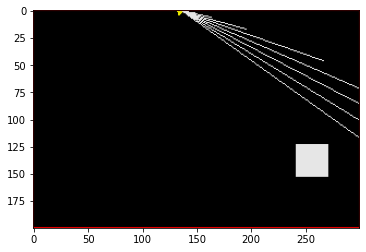

In [52]:
plt.imshow(env.render('rgb_array'))

In [51]:
env.render('rgb_array')

array([[[230,   0,   0],
        [230,   0,   0],
        [230,   0,   0],
        ...,
        [230,   0,   0],
        [230,   0,   0],
        [230,   0,   0]],

       [[230,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [230,   0,   0]],

       [[230,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [230,   0,   0]],

       ...,

       [[230,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [230,   0,   0]],

       [[230,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [230,   0,   0]],

       [[230,   0,   0],
        [230,   0,   0],
        [230,   0,   0],
        ...,
        [230,   0,   0],
        [230,   0,   0],
        [230,   0,   0]]

In [29]:
mode = 'human'
if 'screen' not in globals() or str(screen) == '<Surface(Dead Display)>':
    pygame.init()
    if mode == 'human':
        globals()['screen'] = pygame.display.set_mode(WINDOW_SIZE)
    globals()['display'] = pygame.Surface(WINDOW_SIZE)


In [35]:
env.reset()

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       98.64370723, 97.26853498, 96.39374863, 95.99860189, 96.07072341,
       58.05068572, 39.08013016, 28.75914627, 22.80238769, 18.91153736,
       16.28422912, 14.3462254 , 12.86950078, 11.71465436, 10.79097765,
       10.07365134,  9.4618022 ,  8.98366215,  8.58577818,  8.24702462,
        7.98516018,  7.77277992,  7.6058523 ,  7.48093676,  7.39478317,
        7.34688928,  7.33466526,  7.35817069,  7.41729104,  7.51603498])

In [41]:
import matplotlib.pyplot as plt

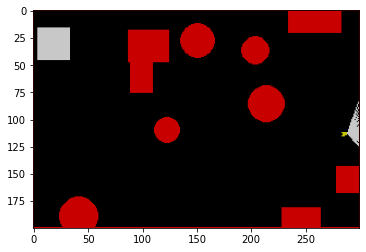

In [43]:
env.reset()
rgb = env.render()
plt.imshow(rgb)

In [45]:
dist(WINDOW_SIZE)

360.5551275463989

In [46]:
a = [5, 6, 7]
b = np.array([3, 4, 5])

In [47]:
np.append(a, b)

array([5, 6, 7, 3, 4, 5])